Project: GLD Options-Based Gold Price Projection

This project analyzes GLD ETF options to estimate expected gold prices and market-implied trends. It uses real-time option chains from Yahoo Finance and computes:
Volume-weighted breakeven prices for calls and puts, converted to USD per ounce of gold.
Forward prices using put–call parity, reflecting the market’s arbitrage-consistent expectation of GLD at the nearest expiry.
Expected percentage change of GLD and implied gold prices relative to the current spot price.
Risk-neutral density estimates via the Breeden–Litzenberger method to visualize the market’s probabilistic view of future prices.
This provides a data-driven view of market expectations, helping traders and analysts understand where the market collectively sees gold moving in the short term.

/tmp/ipykernel_12032/3130220206.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spot_price = gld.history(period="1d")['Close'][-1]


Current GLD spot price: 318.07 USD/share

Sample forward estimates by strike:
   strike   call   put     forward
0   290.0  28.03  0.02  318.049729
1   295.0  18.01  0.02  313.030414
2   298.0  19.25  0.02  317.270825
3   299.0  17.80  0.02  316.820962
4   300.0  16.50  0.01  316.531099

Average forward price per GLD share: 317.06 USD
Expected % change to expiry: -0.32%
Current implied gold price: 3245.61 USD/oz
Expected implied gold price at expiry: 3235.34 USD/oz

Risk-neutral density sample:
   strike  call_price  second_derivative  risk_neutral_density
0   264.0       52.62           0.002042              0.002042
1   265.0       51.63           0.002125              0.002125
2   280.0       37.27          -0.041050             -0.041056
3   290.0       28.03           0.129889              0.129907
4   295.0       18.01          -0.015979             -0.015981


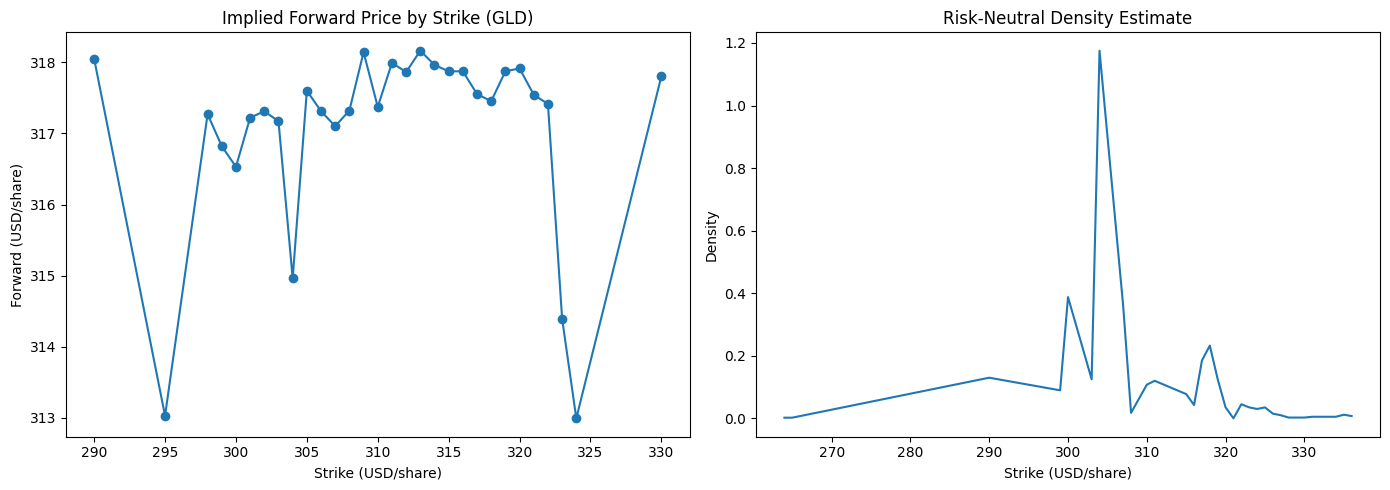

In [ ]:
# Setup: import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Fetch GLD spot price ---
gld = yf.Ticker("GLD")
spot_price = gld.history(period="1d")['Close'][-1]
print(f"Current GLD spot price: {spot_price:.2f} USD/share")

# --- Fetch nearest expiry options chain ---
expiry = gld.options[0]  # nearest expiration
opt = gld.option_chain(expiry)
calls = opt.calls
puts  = opt.puts

# --- Align calls and puts by strike ---
cp = calls[['strike', 'lastPrice']].rename(columns={'lastPrice': 'call'})
pp = puts[['strike', 'lastPrice']].rename(columns={'lastPrice': 'put'})
df = pd.merge(cp, pp, on='strike')

# --- Input risk-free rate and time to maturity ---
r = 0.05  # annual risk-free rate
T = (pd.to_datetime(expiry) - pd.Timestamp.today()).days / 365

# --- Compute implied forward price per strike ---
df['forward'] = df['call'] - df['put'] + df['strike'] * np.exp(r * T)

# Display a sample of forwards
print("\nSample forward estimates by strike:")
print(df[['strike','call','put','forward']].head())

# --- Compute average forward and expected % change ---
forward_mean = df['forward'].mean()
expected_pct_change = (forward_mean / spot_price - 1) * 100
print(f"\nAverage forward price per GLD share: {forward_mean:.2f} USD")
print(f"Expected % change to expiry: {expected_pct_change:.2f}%")

# --- Project expected gold price ---
gold_per_share = 0.098  # GLD ≈ 0.098 oz/share
gold_spot = spot_price / gold_per_share
expected_gold_forward = forward_mean / gold_per_share
print(f"Current implied gold price: {gold_spot:.2f} USD/oz")
print(f"Expected implied gold price at expiry: {expected_gold_forward:.2f} USD/oz")

# --- Estimate risk-neutral density (RND) ---
subs = calls[['strike', 'lastPrice']].dropna().sort_values('strike').reset_index(drop=True)
k = subs['strike'].values
c = subs['lastPrice'].values
d2c = np.gradient(np.gradient(c, k), k)  # second derivative
rnd = np.exp(r * T) * d2c

density_df = pd.DataFrame({
    'strike': k,
    'call_price': c,
    'second_derivative': d2c,
    'risk_neutral_density': rnd
})

# Display sample RND
print("\nRisk-neutral density sample:")
print(density_df.head())

# --- Plot forward estimates and risk-neutral density ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Forward estimates
axes[0].plot(df['strike'], df['forward'], marker='o', linestyle='-')
axes[0].set_title('Implied Forward Price by Strike (GLD)')
axes[0].set_xlabel('Strike (USD/share)')
axes[0].set_ylabel('Forward (USD/share)')

# Risk-neutral density (positive densities only)
positive = density_df[density_df['risk_neutral_density'] > 0]
axes[1].plot(positive['strike'], positive['risk_neutral_density'], linestyle='-')
axes[1].set_title('Risk-Neutral Density Estimate')
axes[1].set_xlabel('Strike (USD/share)')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()


In [20]:
import yfinance as yf
import pandas as pd

# --- Load GLD options chain ---
ticker = yf.Ticker("GLD")
spot_price = gld.history(period="1d")['Close'][-1]
expiry = ticker.options[0]   # nearest expiry
opt_chain = ticker.option_chain(expiry)

calls = opt_chain.calls
puts  = opt_chain.puts

# --- Filter liquid contracts ---
calls_liq = calls[(calls['volume'] > 0) & (calls['lastPrice'] > 0)].copy()
puts_liq  = puts[(puts['volume'] > 0) & (puts['lastPrice'] > 0)].copy()

# --- Gold spot price ---
current_gold_price = 3450  # gold oz price

# --- Calls breakeven ---
calls_liq['breakeven_per_share'] = calls_liq['strike'] + calls_liq['lastPrice']
vw_calls_shr = (calls_liq['breakeven_per_share'] * calls_liq['volume']).sum() / calls_liq['volume'].sum()

# --- Puts breakeven ---
puts_liq['breakeven_per_share'] = puts_liq['strike'] - puts_liq['lastPrice']
vw_puts_shr = (puts_liq['breakeven_per_share'] * puts_liq['volume']).sum() / puts_liq['volume'].sum()

# --- Print results ---
print(f"Spot price of GLD-ETF: {spot_price:,.2f} USD")
print(f"Volume-weighted call breakeven per ounce of gold: {current_gold_price * vw_calls_shr / spot_price:,.2f} USD")
print(f"Volume-weighted put  breakeven per ounce of gold: {current_gold_price * vw_puts_shr / spot_price:,.2f} USD")


/tmp/ipykernel_12032/1693370807.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spot_price = gld.history(period="1d")['Close'][-1]


Spot price of GLD-ETF: 318.07 USD
Volume-weighted call breakeven per ounce of gold: 3,488.47 USD
Volume-weighted put  breakeven per ounce of gold: 3,356.01 USD


In [21]:
import yfinance as yf
import pandas as pd

# Fetch GLD data
gld = yf.Ticker("GLD")
spot_price = gld.history(period="1d")['Close'][-1]
print(f"Current GLD-ETF spot price: {spot_price:.2f} USD/share")

# Get nearest expiry options
expiry = gld.options[0]
opt = gld.option_chain(expiry)
calls = opt.calls.copy()

# Keep only liquid contracts with positive premium
calls_liq = calls[(calls['volume'] > 0) & (calls['lastPrice'] > 0)].copy()

# Compute breakeven per share
calls_liq['breakeven_per_share'] = calls_liq['strike'] + calls_liq['lastPrice']

# Convert to USD per ounce (1 share ≈ 0.1 oz)
calls_liq['breakeven_per_oz'] = calls_liq['breakeven_per_share'] / 0.1

# Compute volume-weighted breakeven (per share and per oz)
vw_breakeven_share = (calls_liq['breakeven_per_share'] * calls_liq['volume']).sum() / calls_liq['volume'].sum()

print(f"Volume-weighted call breakeven per share: {vw_breakeven_share:.2f} USD")

# Sanity check: min individual breakeven >= spot
min_breakeven = calls_liq['breakeven_per_share'].min()
if min_breakeven < spot_price:
    print("Warning: Some breakevens below spot — check data or stale options!")


/tmp/ipykernel_12032/171553652.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spot_price = gld.history(period="1d")['Close'][-1]


Current GLD-ETF spot price: 318.07 USD/share
Volume-weighted call breakeven per share: 321.62 USD
